**Idea**: Implement Context Encoder + SRCNN  
**Framework**: Keras-Core  
**Date**: 02/11/2023  

### Libraries


In [126]:
'general use imports'
import os
import wget
import tarfile
import numpy as np
import shutil

import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.util import img_as_float

'machine learning imports'
import keras_core as keras
from keras import layers
os.environ["KERAS_BACKEND"] = "tensorflow"

### Data

In [ ]:
# Downloading the data
url_voc = "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar"
os.makedirs(os.path.join(".", "data_voc2007"), exist_ok=True)
wget.download(url = url_voc, out = "data_voc2007")

# Extracting the data
tar = tarfile.open("data_voc2007/VOCtrainval_06-Nov-2007.tar")
tar.extractall("data_voc2007")
tar.close()
os.remove("data_voc2007/VOCtrainval_06-Nov-2007.tar")

'data_voc2007/VOCtrainval_06-Nov-2007.tar'

In [ ]:
# Extracting the data
tar = tarfile.open("data_voc2007/VOCtrainval_06-Nov-2007.tar")
tar.extractall("data_voc2007")
tar.close()
os.remove("data_voc2007/VOCtrainval_06-Nov-2007.tar")

No of images: 5011


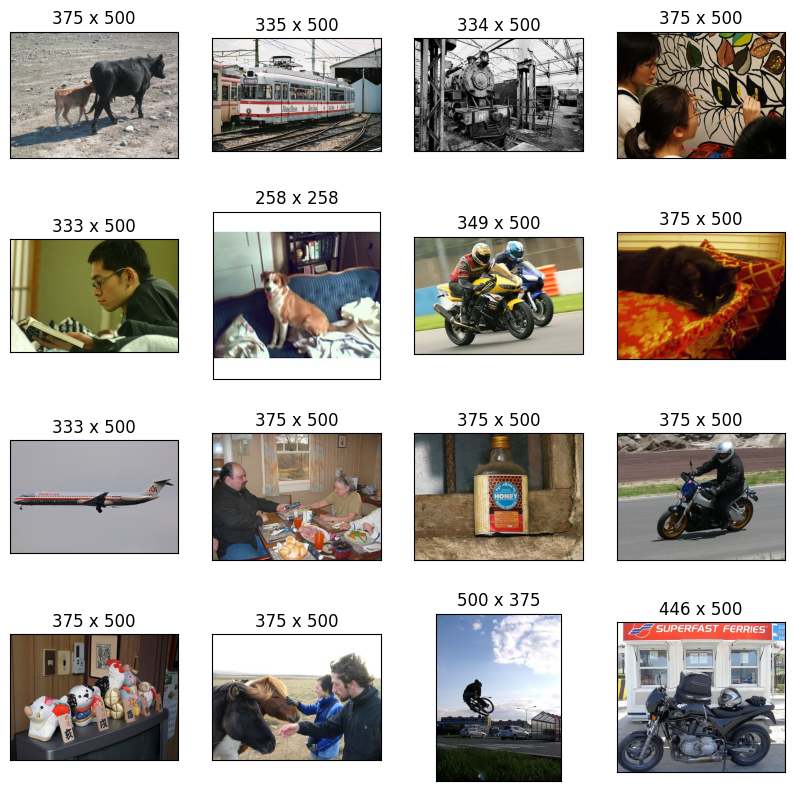

In [93]:
voc_img_dir = os.path.join(".", "data_voc2007", "JPEGImages")
# plot 16 random images in a 4x4 grid

import matplotlib.pyplot as plt
import random
import numpy as np

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i, axi in enumerate(ax.flat):
    img = plt.imread(os.path.join(voc_img_dir, random.choice(os.listdir(voc_img_dir))))
    axi.imshow(img)
    # title with dimensions
    axi.set(xticks=[], yticks=[], title=str(f"{img.shape[0]} x {img.shape[1]}"))

# number of images, maximum dimensions
n_images = len(os.listdir(voc_img_dir))
print(f"No of images: {n_images}")

### Mask Generation

In [ ]:
def sq_mask(image, max_mask_size=0.5):
    """
    Generate a square mask for an image.
    """
    # get image dimensions
    height, width = image.shape[:2]
    # Check which dimension is smaller
    if height < width:
        mask_size = np.random.randint(1, int(height * max_mask_size))
    else:
        mask_size = np.random.randint(1, int(width * max_mask_size))    
    
    # generate random coordinates
    x1 = np.random.randint(0, width - mask_size)
    x2 = (x1 + mask_size) 
    y1 = np.random.randint(0, height - mask_size)
    y2 = y1 + mask_size
    # print (f"Img dims: {height} x {width}, Mask coords: ({x1}, {x2}), ({y1}, {y2})")	
    # create mask
    mask = np.zeros((height, width))
    mask[y1:y2, x1:x2] = 1
    return mask

def apply_mask(image, mask):
    """
    Apply mask to image.
    """
    masked_image = image.copy()
    masked_image[mask == 1] = 0
    return masked_image

def del_folder_content(folder):
    """
    Delete the content of a folder.
    """
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))


In [ ]:
os.makedirs(os.path.join(".", "data_voc2007", "JPEGImages_masked"), exist_ok=True)

# create masked images
for img_name in os.listdir(voc_img_dir):
    img = plt.imread(os.path.join(voc_img_dir, img_name))
    mask = sq_mask(img)
    masked_img = apply_mask(img, mask)
    plt.imsave(os.path.join(".", "data_voc2007", "JPEGImages_masked", img_name), masked_img)
    print(f"Masked image {img_name} saved.", end='\r', flush=True)

### Image Generator

In [112]:
class ImageGenerator(keras.utils.Sequence):
    def __init__(self, masked_dir, original_dir, batch_size=32, target_size=(128, 128)):
        self.data = data
        self.index = 0
        
        self.masked_dir = masked_dir
        self.original_dir = original_dir
        self.batch_size = batch_size
        self.target_size = target_size

        # Get the list of image filenames
        self.masked_filenames = sorted(os.listdir(masked_dir))
        self.original_filenames = sorted(os.listdir(original_dir))

        # Get the total number of images
        self.num_images = len(self.masked_filenames)
    
    def __iter__(self):
        return self

    def __len__(self):
        return int(np.ceil(self.num_images / self.batch_size))

    def __getitem__(self, idx):
        # Get the batch of image indices
        batch_indices = range(idx * self.batch_size, min((idx + 1) * self.batch_size, self.num_images))

        # Load the images and masks
        masked_images = np.empty((self.batch_size, *self.target_size, 3))
        original_images = np.empty((self.batch_size, *self.target_size, 3))
        for i, batch_idx in enumerate(batch_indices):
            # Load the masked image
            masked_image = cv2.imread(os.path.join(self.masked_dir, self.masked_filenames[batch_idx]))
            masked_image = cv2.resize(masked_image, self.target_size)
            masked_images[i] = masked_image

            # Load the original image
            original_image = cv2.imread(os.path.join(self.original_dir, self.original_filenames[batch_idx]))
            original_image = cv2.resize(original_image, self.target_size)
            original_images[i] = original_image

        # Normalize the images
        masked_images = masked_images.astype('float32') / 255
        original_images = original_images.astype('float32') / 255

        return masked_images, original_images

In [150]:
class ImageGenerator(keras.utils.Sequence):
    def __init__(self, masked_dir, original_dir, batch_size=32, target_size=(128, 128)):
        self.masked_dir = masked_dir
        self.original_dir = original_dir
        self.batch_size = batch_size
        self.target_size = target_size

        # Get the list of image filenames
        self.masked_filenames = sorted(os.listdir(masked_dir))
        self.original_filenames = sorted(os.listdir(original_dir))

        # Get the total number of images
        self.num_images = len(self.masked_filenames)
    
    def __len__(self):
        return int(np.ceil(self.num_images / self.batch_size))

    def __getitem__(self, idx):
        # Get the batch of image indices
        batch_indices = range(idx * self.batch_size, min((idx + 1) * self.batch_size, self.num_images))

        # Load the images and masks
        masked_images = np.empty((self.batch_size, *self.target_size, 3))
        original_images = np.empty((self.batch_size, *self.target_size, 3))
        for i, batch_idx in enumerate(batch_indices):
            # Load the masked image
            masked_image = cv2.imread(os.path.join(self.masked_dir, self.masked_filenames[batch_idx]))
            masked_image = cv2.resize(masked_image, self.target_size)
            masked_images[i] = masked_image

            # Load the original image
            original_image = cv2.imread(os.path.join(self.original_dir, self.original_filenames[batch_idx]))
            original_image = cv2.resize(original_image, self.target_size)
            original_images[i] = original_image

        # Normalize the images
        masked_images = masked_images.astype('float32') / 255
        original_images = original_images.astype('float32') / 255

        return masked_images, original_images


### Model Definition

# MUDAR MODELO PARA SEPARABLE CONVOLUTIONS E POR DE LADO CONFIGURABILIDADE...

In [179]:
class UNet(keras.Model):
    """	
    U-Net model class.
    """
    def __init__(self, conv_type='Conv2D', activation='LeakyReLU', 
    residual=False, attention=False, filters=64, filter_size=3, num_classes=1):
        super(UNet, self).__init__()
        self.conv_type = conv_type
        self.activation = activation
        self.residual = residual
        self.attention = attention
        self.filters = filters
        self.filter_size = filter_size
        self.num_classes = num_classes

    def call(self, inputs, training=False):
        
        # Encoder
        print(f"Input: inputs.shape {inputs.shape}")
        x = self.conv_block(inputs, self.filters, self.filter_size)
        print(f"Conv1: x.shape {x.shape}")
        p1 = self.conv_block(x, self.filters*2, self.filter_size)
        print(f"Conv2: p1.shape {p1.shape}")
        p2 = self.conv_block(p1, self.filters*4, self.filter_size)
        print(f"Conv3: p2.shape {p2.shape}")
        p3 = self.conv_block(p2, self.filters*8, self.filter_size)

        # Bottleneck
        print(f"Conv4: p3.shape {p3.shape}")
        x = self.conv_block(p3, self.filters*16, self.filter_size)
        
        # Decoder
        print(f"Conv5: x.shape {x.shape}")
        x = self.up_conv(x, self.filters*8, self.filter_size)
        print(f"UpConv1: x.shape {x.shape}")
        x = layers.Concatenate(axis=-1)([x, p3])
        print(f"Concat1: x.shape {x.shape}")
        x = self.conv_block(x, self.filters*8, self.filter_size)
        print(f"Conv6: x.shape {x.shape}")   
        x = self.up_conv(x, self.filters*4, self.filter_size)
        print(f"UpConv2: x.shape {x.shape}")
        x = layers.Concatenate(axis=-1)([x, p2])
        print(f"Concat2: x.shape {x.shape}")
        x = self.conv_block(x, self.filters*4, self.filter_size)
        print(f"Conv7: x.shape {x.shape}")
        x = self.up_conv(x, self.filters*2, self.filter_size)
        print(f"UpConv3: x.shape {x.shape}")
        x = layers.Concatenate(axis=-1)([x, p1])
        print(f"Concat3: x.shape {x.shape}")
        x = self.conv_block(x, self.filters*2, self.filter_size)
        print(f"Conv8: x.shape {x.shape}")
        x = self.up_conv(x, self.filters, self.filter_size)
        print(f"UpConv4: x.shape {x.shape}")
        x = layers.Concatenate(axis=-1)([x, inputs])
        print(f"Concat4: x.shape {x.shape}")
        x = self.conv_block(x, self.filters, self.filter_size)

        
        # Segmentation output
        # activation = 'sigmoid' if self.num_classes == 1 else 'softmax'
        # outputs = Conv2D(self.num_classes, (1, 1), activation=activation)(x)

        # Generative output (3 channels)
        print(f"Conv9: x.shape {x.shape}")
        outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(x)

        return outputs

    def conv_block(self, inputs, filters, filter_size):
        # x = self.conv_layer(inputs, filters, filter_size)
        # x = self.conv_layer(x, filters, filter_size)
        x = layers.Conv2D(filters, (filter_size, filter_size), 
                            padding='same', activation = self.activation)(inputs)
        x = layers.Conv2D(filters, (filter_size, filter_size),
                            padding='same', activation = self.activation)(x)
        return x

    # def conv_layer(self, inputs, filters, filter_size):
    #     if self.conv_type == 'Conv2D':
    #         return layers.Conv2D(filters, (filter_size, filter_size), 
    #                         padding='same', activation = self.activation)(inputs)
    #     elif self.conv_type == 'DepthwiseSeparableConv2D':
    #         return layers.DepthwiseConv2D(filters, (filter_size, filter_size), 
    #                         padding='same', activation = self.activation)(inputs)

    def up_conv(self, inputs, filters, filter_size):
        x = layers.UpSampling2D((2, 2))(inputs)
        x = layers.Conv2D(filters, (filter_size, filter_size), padding='same')(x)
        # x = layers.Conv2DTranspose(filters, (filter_size, filter_size), 
        #     strides=(2, 2), padding='same', activation = self.activation)(inputs)
        return x

### Test set creation

In [102]:
# imags with masks and without masks folders
img_dir = os.path.join(".", "data_voc2007", "JPEGImages")
mask_dir = os.path.join(".", "data_voc2007", "JPEGImages_masked")

# create test image and masked image directories and move images 10% total images
os.makedirs(os.path.join(".", "data_voc2007", "JPEGImages_test"), exist_ok=True)
os.makedirs(os.path.join(".", "data_voc2007", "JPEGImages_masked_test"), exist_ok=True)

# move 10% of images to test directories
for i, filename in enumerate(os.listdir(img_dir)):
    if i % 10 == 0:
        shutil.move(os.path.join(img_dir, filename), os.path.join(".", "data_voc2007", "JPEGImages_test", filename))
        shutil.move(os.path.join(mask_dir, filename), os.path.join(".", "data_voc2007", "JPEGImages_masked_test", filename))

In [103]:
# create validation image and masked image directories and move images 10% total images
os.makedirs(os.path.join(".", "data_voc2007", "JPEGImages_val"), exist_ok=True)
os.makedirs(os.path.join(".", "data_voc2007", "JPEGImages_masked_val"), exist_ok=True)

# move 10% of images to validation directories
for i, filename in enumerate(os.listdir(img_dir)):
    if i % 10 == 0:
        shutil.move(os.path.join(img_dir, filename), os.path.join(".", "data_voc2007", "JPEGImages_val", filename))
        shutil.move(os.path.join(mask_dir, filename), os.path.join(".", "data_voc2007", "JPEGImages_masked_val", filename))

In [172]:
# define image and mask directories
train_masked_dir = os.path.join(".", "data_voc2007", "JPEGImages_masked")
train_original_dir = os.path.join(".", "data_voc2007", "JPEGImages")
validation_masked_dir = os.path.join(".", "data_voc2007", "JPEGImages_masked_val")
validation_original_dir = os.path.join(".", "data_voc2007", "JPEGImages_val")
test_masked_dir = os.path.join(".", "data_voc2007", "JPEGImages_masked_test")
test_original_dir = os.path.join(".", "data_voc2007", "JPEGImages_test")

# create generators
train_generator = ImageGenerator(train_masked_dir, train_original_dir, target_size=(256, 256), batch_size=32)
validation_generator = ImageGenerator(validation_masked_dir, validation_original_dir, target_size=(256, 256), batch_size=32)
test_generator = ImageGenerator(test_masked_dir, test_original_dir,target_size=(256, 256), batch_size=32)

In [180]:
# define UNet model
model = UNet(conv_type='DepthwiseSeparableConv2D', 
             activation='LeakyReLU', 
             filters=32, 
             filter_size=3)

In [181]:
from keras import backend as K

def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[PSNR])

In [182]:
model.build(input_shape=(None, 256, 256, 3))
model.summary()

Model: "u_net_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [183]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, verbose=1, shuffle=True)

Epoch 1/10
Input: inputs.shape (None, 256, 256, 3)
Conv1: x.shape (None, 256, 256, 32)
Conv2: p1.shape (None, 256, 256, 64)
Conv3: p2.shape (None, 256, 256, 128)
Conv4: p3.shape (None, 256, 256, 256)
Conv5: x.shape (None, 256, 256, 512)
UpConv1: x.shape (None, 512, 512, 256)


ValueError: Exception encountered when calling UNet.call().

[1mA `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 512, 512, 256), (None, 256, 256, 256)][0m

Arguments received by UNet.call():
  • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)
  • training=True